In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


In [9]:
!pip install pytorch-lightning


In [8]:
!pip install pytorch-metric-learning


In [3]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ----------- ---------------------------- 20.7/72.0 MB 109.3 MB/s eta 0:00:01
   ------------------------ --------------- 44.8/72.0 MB 109.8 MB/s eta 0:00:01
   ---------------------------------------  70.3/72.0 MB 112.0 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 99.7 MB/s  0:00:00


In [2]:
# ================================================================
# NOTEBOOK: Siamese Triplet + FC + XGBoost + Embedding visuals per epoch
# ================================================================
# 0) IMPORTS
# ================================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import pytorch_lightning as pl
from pytorch_metric_learning.losses import ContrastiveLoss
from pytorch_metric_learning.miners import PairMarginMiner

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ajustes de visualización
sns.set()
plt.rcParams["figure.figsize"] = (9,6)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [3]:
# ================================================================
# 1) DATA TRANSFORMS + DATASET
# ================================================================
DATASET_ROOT = "Data1"

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_ROOT, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATASET_ROOT, "val"),   transform=test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATASET_ROOT, "test"),  transform=test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print("Clases detectadas:", class_names)

Clases detectadas: ['Abutilon Indicum', 'Aloe barbadensis miller', 'Calotropis gigantea', 'Canna indica', 'Cissus quadrangularis', 'Curcuma longa', 'Eclipta prostrate', 'Eichhornia Crassipes', 'Hibiscus Rosasinensis', 'Ixora coccinea', 'Justica adhatoda', 'Murraya koenigii', 'Ocimum tenuiflorum', 'Ouretlanata', 'Phyllanthus amarus', 'Ricinus communis', 'Senna Atriculata', 'Sesbania grandiflora', 'Trifolium Repens', 'Ziziphus mauritiana']


In [4]:
# ================================================================
# 2) SIAMESE NETWORK
# ================================================================
class SiameseBackbone(nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT")
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)

siamese = SiameseBackbone().to(device)

In [5]:
# ================================================================
# 3) PYTORCH LIGHTNING TRAINER PARA TRIPLET LOSS
# ================================================================
class ContrastiveLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4, margin=0.2):
        super().__init__()
        self.model = model
        self.miner = PairMarginMiner(pos_margin=0.5, neg_margin=1.0)
        self.loss_func = ContrastiveLoss(pos_margin=0.5, neg_margin=1.0)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        embeddings = self(imgs)
        pairs = self.miner(embeddings, labels)
        loss = self.loss_func(embeddings, labels, pairs)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

lightning_model = ContrastiveLightning(siamese)

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger("logs", "contrastive")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator=device,
    log_every_n_steps=20,
    logger=logger   # ← sin esto, SIEMPRE falla
)

trainer.fit(lightning_model, train_loader)

# ⭐ GUARDAR MODELO SIAMÉS
torch.save(siamese.state_dict(), "siamese_contrastive_backbone.pth")
print("Modelo siamés guardado como siamese_contrastive_backbone.pth")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | SiameseBackbone | 23.8 M | train
1 | miner     | PairMarginMiner | 0      | train
2 | loss_func | ContrastiveLoss | 0      | train
------------------------------------------------------
23.8 M   

Epoch 4: 100%|██████████| 55/55 [01:23<00:00,  0.66it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 55/55 [01:24<00:00,  0.65it/s, v_num=1]
Modelo siamés guardado como siamese_contrastive_backbone.pth


In [ ]:
# ================================================================
# 4) CLASIFICADOR FC (BACKBONE CONGELADO)
# ================================================================
class Classifier(nn.Module):
    def __init__(self, backbone, emb_size, num_classes):
        super().__init__()
        for p in backbone.parameters():
            p.requires_grad = False

        self.backbone = backbone
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        with torch.no_grad():
            emb = self.backbone(x)
        return self.fc(emb)

classifier = Classifier(siamese, 128, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.fc.parameters(), lr=1e-3)

for epoch in range(8):
    classifier.train()
    running_loss = 0
    for img, lbl in train_loader:
        img, lbl = img.to(device), lbl.to(device)

        optimizer.zero_grad()
        out = classifier(img)
        loss = criterion(out, lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

# ⭐ GUARDAR CLASIFICADOR FC
torch.save(classifier.state_dict(), "classifier_fc_contrast.pth")
print("Clasificador FC guardado como classifier_fc_contrast.pth")

Epoch 1 - Loss: 2.4858
Epoch 2 - Loss: 1.6193
Epoch 3 - Loss: 1.0507
Epoch 4 - Loss: 0.7254
Epoch 5 - Loss: 0.5572
Epoch 6 - Loss: 0.4305
Epoch 7 - Loss: 0.3436
Epoch 8 - Loss: 0.2949
Clasificador FC guardado como classifier_fc_contrast.pth


In [7]:
# ================================================================
# 5) EVALUACIÓN DEL CLASIFICADOR FC
# ================================================================
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            p = out.argmax(1).cpu().numpy()
            preds.extend(p)
            labels.extend(y.numpy())

    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return acc, f1, labels, preds

acc, f1, y_true, y_pred = evaluate(classifier, test_loader)

print("Accuracy FC:", acc)
print("F1-score FC:", f1)


Accuracy FC: 0.9822784810126582
F1-score FC: 0.9841169672070876


In [8]:
# ================================================================
# 6) EXTRAER EMBEDDINGS (PARA XGBOOST)
# ================================================================
def extract_embeddings(model, loader):
    model.eval()
    all_emb, all_lbl = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            all_emb.append(emb)
            all_lbl.append(y.numpy())

    return np.vstack(all_emb), np.hstack(all_lbl)

train_emb, train_lbl = extract_embeddings(siamese, train_loader)
test_emb,  test_lbl  = extract_embeddings(siamese, test_loader)

print("Embeddings shape:", train_emb.shape)

Embeddings shape: (1751, 128)


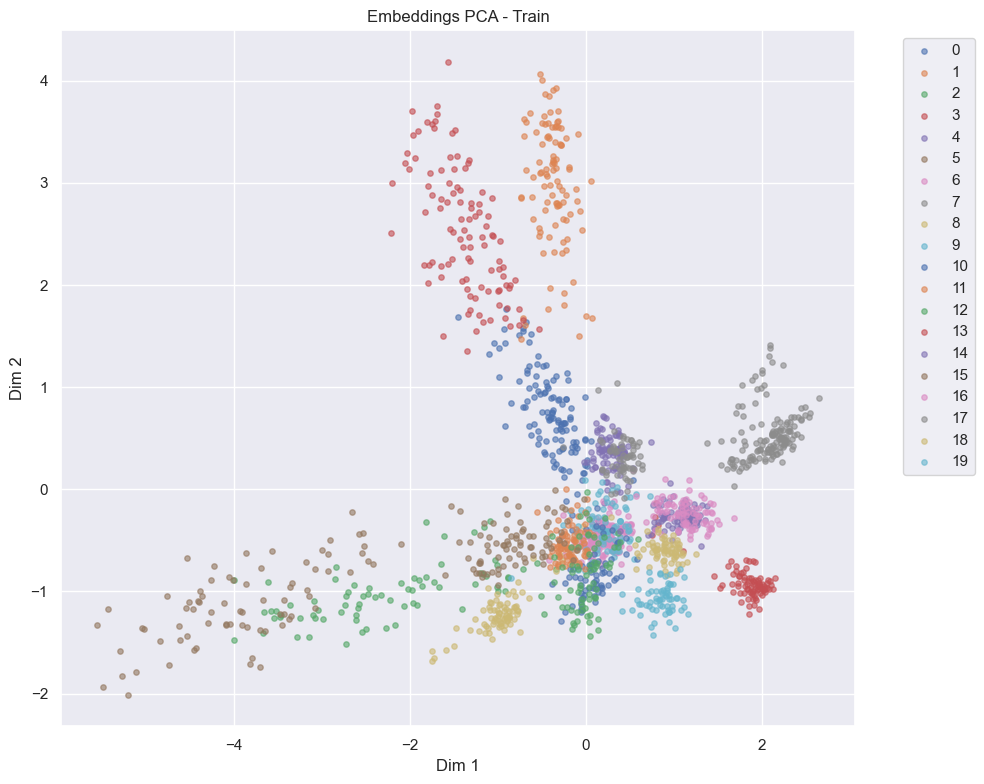

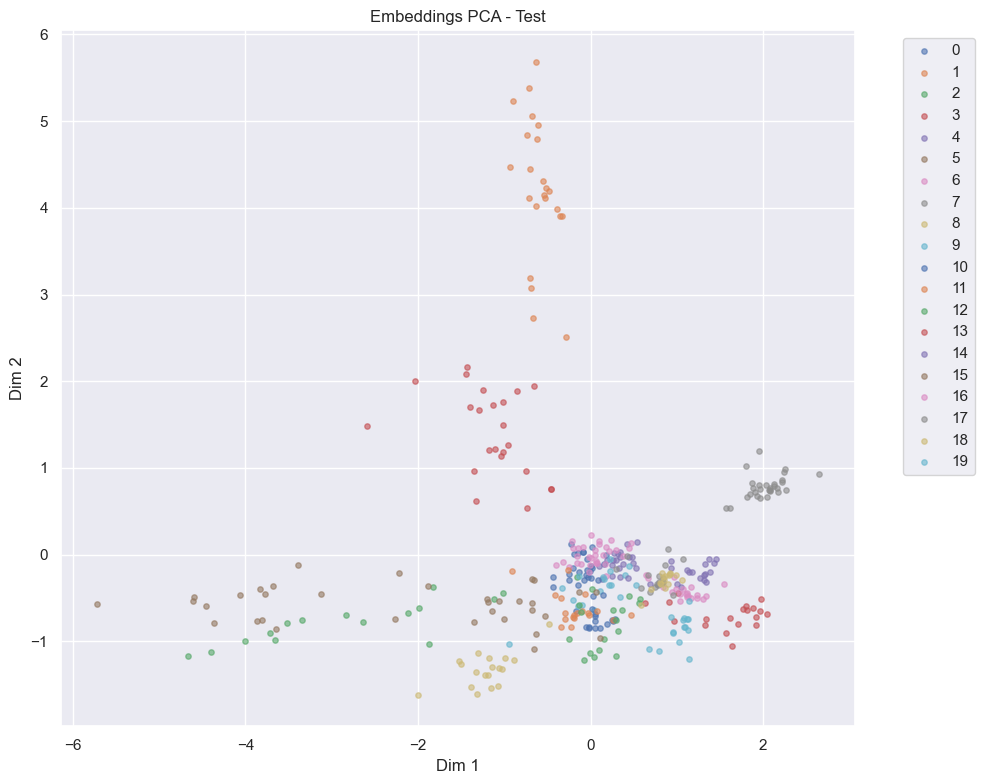

In [9]:
# ================================================================
# 6.1) VISUALIZAR EMBEDDINGS EN 2D
# ================================================================
def plot_embeddings(embeddings, labels, method="pca", title="Embeddings 2D"):
    """
    embeddings: np.array (N, embedding_dim)
    labels: np.array (N,)
    method: "pca" o "tsne"
    """
    if method.lower() == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)
        
    emb_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    num_classes = len(np.unique(labels))
    for c in range(num_classes):
        idx = labels == c
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=str(c), alpha=0.6, s=15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

# Visualizar embeddings de entrenamiento
plot_embeddings(train_emb, train_lbl, method="pca", title="Embeddings PCA - Train")

# Visualizar embeddings de test
plot_embeddings(test_emb, test_lbl, method="pca", title="Embeddings PCA - Test")

In [10]:
# ================================================================
# 7) XGBOOST PARA CLASIFICAR EMBEDDINGS
# ================================================================
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='mlogloss'
)

xgb.fit(train_emb, train_lbl)
xgb_preds = xgb.predict(test_emb)

acc_xgb = accuracy_score(test_lbl, xgb_preds)
f1_xgb  = f1_score(test_lbl, xgb_preds, average="macro")

print("🎯 XGBoost Accuracy:", acc_xgb)
print("🔥 XGBoost F1-score:", f1_xgb)

🎯 XGBoost Accuracy: 0.9670886075949368
🔥 XGBoost F1-score: 0.9661978257043724


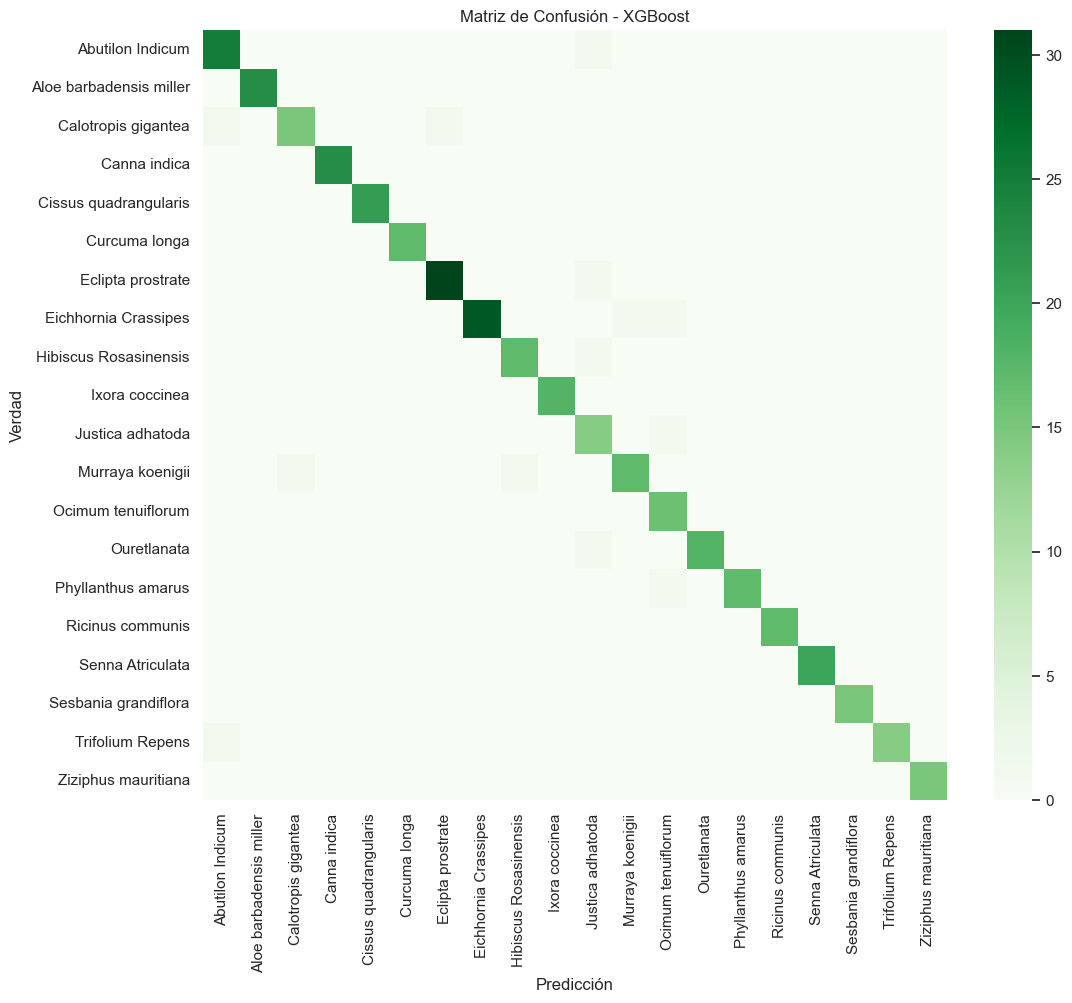

In [11]:
# ================================================================
# 8) MATRIZ DE CONFUSIÓN XGBOOST
# ================================================================
cm = confusion_matrix(test_lbl, xgb_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Verdad")
plt.show()

In [12]:
# ================================================================
# 9) GUARDAR MODELOS
# ================================================================
torch.save(siamese.state_dict(), "siamese_contrastive_backbone.pth")
torch.save(classifier.state_dict(), "classifier_fc_contrastive.pth")
xgb.save_model("xgboost_contrastive.json")
print("✅ Modelos guardados en la carpeta del notebook")

✅ Modelos guardados en la carpeta del notebook


In [15]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

# ------------------------------
# Configuración
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = "Data1"  # Cambia según tu ruta
batch_size = 32

# ------------------------------
# Transformaciones del test set
# ------------------------------
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(DATASET_ROOT, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ------------------------------
# Reconstruir la red siamesa
# ------------------------------
class SiameseBackbone(torch.nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT")
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)

siamese = SiameseBackbone(embedding_size=128).to(device)
siamese.load_state_dict(torch.load("siamese_contrastive_backbone.pth", map_location=device))
siamese.eval()

# ------------------------------
# Extraer embeddings del test set
# ------------------------------
def extract_embeddings(model, loader):
    model.eval()
    all_emb, all_lbl = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            all_emb.append(emb)
            all_lbl.append(y.numpy())
    return np.vstack(all_emb), np.hstack(all_lbl)

test_emb, test_lbl = extract_embeddings(siamese, test_loader)

# ------------------------------
# Cargar XGBoost
# ------------------------------
xgb = XGBClassifier()
xgb.load_model("xgboost_contrastive.json")
xgb_preds = xgb.predict(test_emb)

# ------------------------------
# Métricas finales
# ------------------------------
acc = accuracy_score(test_lbl, xgb_preds)
precision = precision_score(test_lbl, xgb_preds, average="macro")
f1 = f1_score(test_lbl, xgb_preds, average="macro")
cm = confusion_matrix(test_lbl, xgb_preds)

print("🎯 XGBoost Test Accuracy :", acc)
print("⚡ XGBoost Test Precision:", precision)
print("🔥 XGBoost Test F1-score :", f1)
print("Matriz de confusión (normalizada):")
print(cm)


C:\Users\macrio-patrick\AppData\Local\Temp\ipykernel_22092\1512450365.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siamese.load_state_dict(torch.load("siamese_contra

🎯 XGBoost Test Accuracy : 0.9670886075949368
⚡ XGBoost Test Precision: 0.9670473927875243
🔥 XGBoost Test F1-score : 0.9661978257043724
Matriz de confusión (normalizada):
[[25  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 15  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 31  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 29  0  0  0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  1  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0 

In [22]:
# ================================================================
# 10) BUSCADOR DE SIMILITUD - TOP 10 IMÁGENES MÁS CERCANAS
# ================================================================
from PIL import Image
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import os
import numpy as np

# --- 10.1 Extraer embeddings de un folder (base de búsqueda) ---
def compute_embeddings_for_folder(model, folder_path, transform, device="cuda"):
    model.eval()
    embeddings = []
    paths = []

    # Recorremos TODAS las subcarpetas (clases)
    for root, dirs, files in os.walk(folder_path):
        for fname in files:
            fpath = os.path.join(root, fname)

            try:
                img = Image.open(fpath).convert("RGB")
            except:
                continue

            x = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = model(x).cpu().numpy().flatten()

            embeddings.append(emb)
            paths.append(fpath)

    return np.array(embeddings), paths

# --- 10.2 TOP-10 similares ---
def top_k_similar(model, input_image_path, db_embeddings, db_paths, transform, k=10, device="cuda"):
    model.eval()

    img = Image.open(input_image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model(x).cpu().numpy().reshape(1, -1)

    # Distancias cosine
    dist = cosine_distances(emb, db_embeddings)[0]
    idx = np.argsort(dist)[:k]

    return [(db_paths[i], dist[i]) for i in idx]


# --- 10.3 Mostrar resultados visualmente ---
def show_similarity_results(input_path, results):
    plt.figure(figsize=(15, 8))

    # Mostrar input
    plt.subplot(2, 6, 1)
    plt.imshow(Image.open(input_path))
    plt.title("INPUT")
    plt.axis("off")

    # Mostrar top 10
    for i, (path, d) in enumerate(results):
        plt.subplot(2, 6, i+2)
        plt.imshow(Image.open(path))
        plt.title(f"{i+1} | dist={d:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [23]:
# Folder que servirá como base (puedes usar train/val/test)
BASE_FOLDER = os.path.join(DATASET_ROOT, "train")

# Extraer embeddings de la base
db_embeddings, db_paths = compute_embeddings_for_folder(
    model=siamese,
    folder_path=BASE_FOLDER,
    transform=test_transform,
    device=device
)

print("Base de embeddings cargada:", db_embeddings.shape)
print(DATASET_ROOT)


Base de embeddings cargada: (1751, 128)
Data1


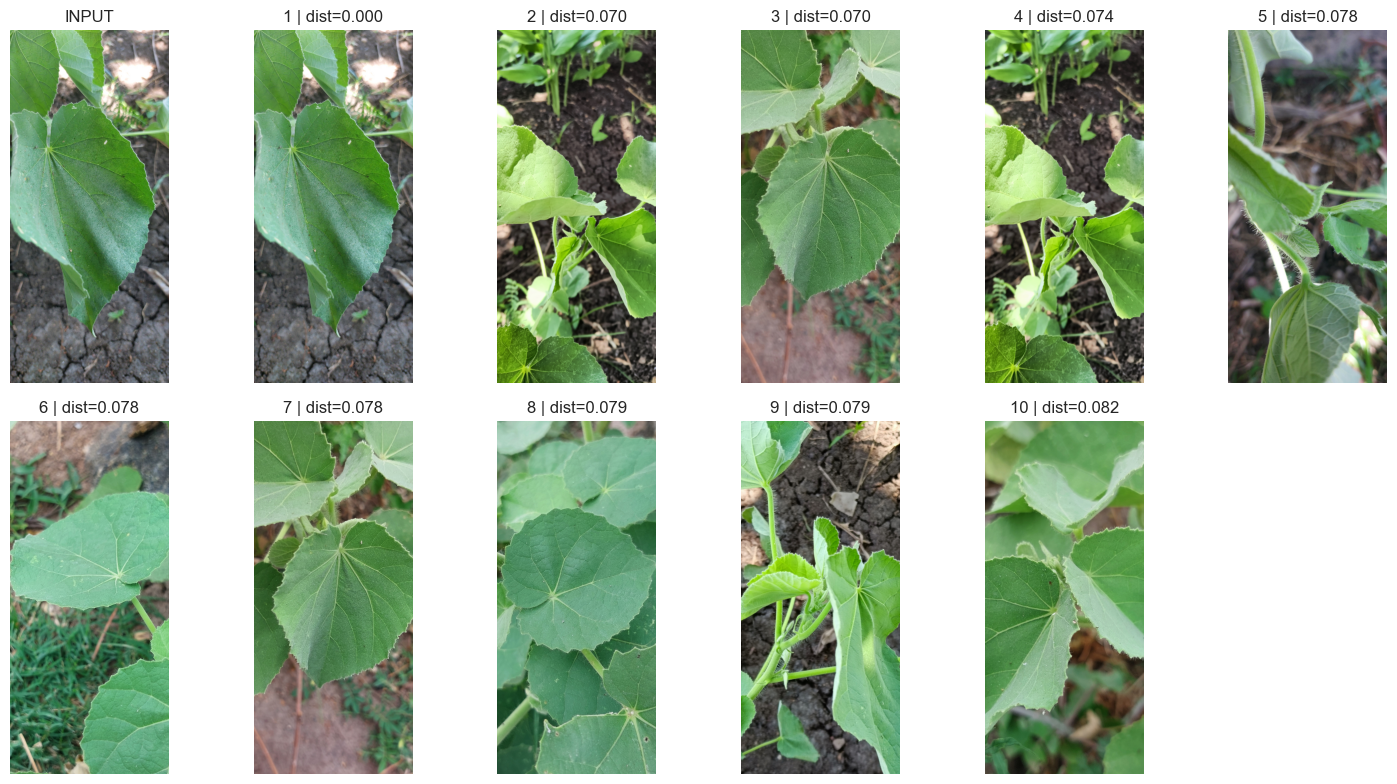

In [25]:
input_image = "Data1/train/Abutilon Indicum/000.jpg"

results = top_k_similar(
    model=siamese,
    input_image_path=input_image,
    db_embeddings=db_embeddings,
    db_paths=db_paths,
    transform=test_transform,
    device=device
)

show_similarity_results(input_image, results)
